## Overview of core astropy.modeling features

- simple models
- fitters
- combined models
- creating new models


In [41]:
import numpy as np
%matplotlib inline
from matplotlib import pyplot as plt

### Simple models

In [42]:
from astropy.modeling import models, fitting


Models are defined with their parameters.

In [44]:
models.Gaussian1D.param_names

('amplitude', 'mean', 'stddev')

In [45]:
gauss = models.Gaussian1D(amplitude=5.3, mean=3.1, stddev=1.1)

Parameters are objects with attributes:

In [46]:
gauss.mean

Parameter('mean', value=3.1)

In [47]:
print(gauss.mean.name)

mean


In [48]:
print(gauss.mean.value)


3.1


In [49]:
print(gauss.mean.default)

0


In [50]:
models.Gaussian1D(amplitude=1, stddev=1)

<Gaussian1D(amplitude=1.0, mean=0.0, stddev=1.0)>

Modeling supports parameter constraints:

In [51]:
print(gauss.mean.constraints) # more on this later

(u'fixed', u'tied', u'bounds')


In [52]:
print(gauss.parameters)

[ 5.3  3.1  1.1]


Parameter values can be changed by simple assignment:

In [53]:
gauss.mean = 1.4
print(gauss.mean)

Parameter('mean', value=1.4)


In [54]:
print(gauss.parameters)

[ 5.3  1.4  1.1]


Models are evaluated like functions, by passing the inputs. Each dimension is a separate input.

In [55]:
x = np.linspace(-2, 5, 100)
data = gauss(x)

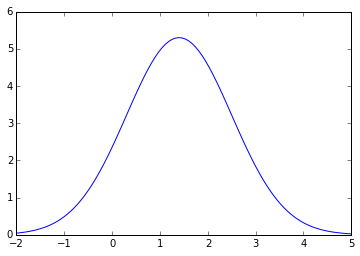

In [56]:
plt.plot(x, data)


Add noise to the data and fit a gaussian.

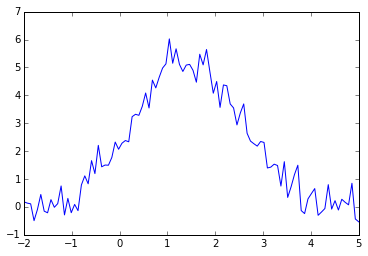

In [57]:
data = gauss(x) + np.random.normal(0, 0.4, x.shape)
plt.plot(x, data)

### Fitters

Create a fitter which uses the Levenberg-Marquardt optimization algorithm and least squares statistics.
Then pass the model and the data to the fitter. The output is a new model with fitted parameters.


In [58]:
fitter = fitting.LevMarLSQFitter()
model = fitter(gauss, x, data)

In [59]:
print(model.parameters)

[ 5.28625385  1.41799262  1.09902297]


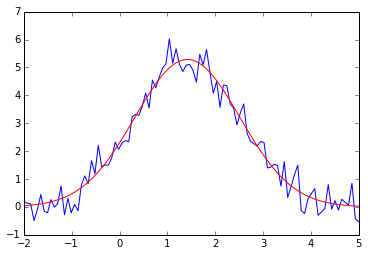

In [60]:
plt.plot(x, data)
plt.plot(x, model(x), 'r')

Fitters support parameter constraints of type `fixed`, `tied` and `bounds`.
Let's constrain the amplitude to its initial value of 5.3.

In [61]:
gauss.amplitude.fixed = True
model = fitter(gauss, x, data)
print(model.parameters)

[ 5.3         1.41794262  1.09715346]


Bounds can be set on a parameter either by using `min` and `max` or the `bounds` attribute.

In [25]:
gauss.stddev.min = .1
gauss.stddev.max = .6
print(gauss.stddev.bounds)

(0.1, 0.6)


To show the mechanism of tieing (or linking) two parameters in the next example the stddev parameter is tied to the amplitude.

In [26]:
def tie_stddev_ampl(model):
    return model.amplitude / 3.78
gauss.stddev.tied = tie_stddev_ampl

Model: Gaussian1D
Inputs: (u'x',)
Outputs: (u'y',)
Model set size: 1
Parameters:
    amplitude      mean         stddev   
    --------- ------------- -------------
          5.3 1.36405465947 1.40211640212


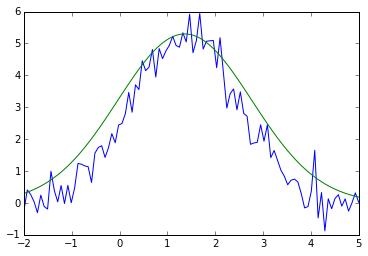

In [27]:
model_tied = fitter(gauss, x, data)
print(model_tied)
plt.plot(x, data)
plt.plot(x, model_tied(x))

Support for parameter cinstraints varies between fitters. To see what is supported:

In [28]:
print(fitting.LevMarLSQFitter.supported_constraints)

[u'fixed', u'tied', u'bounds']


astropy.modeling has several other fitters: SimplexLSQFitter, SLSQPLSQFitter and LinearLSQFitter.
The last one can be used only with linear models and provides an exact solution.

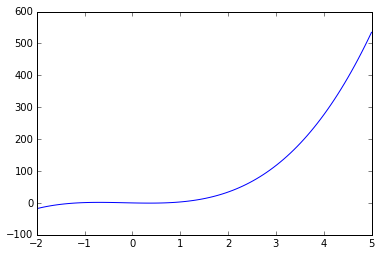

In [29]:
cheb1 = models.Chebyshev1D(degree=3, c0=1, c2=1, c3=1)
plt.plot(x, cheb1(x))

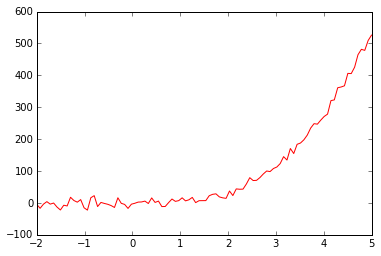

In [30]:
data = cheb1(x) + np.random.normal(0, 10, x.shape)
plt.plot(x, data, 'r')

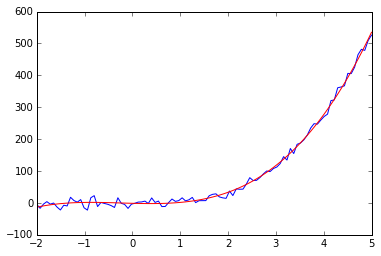

In [31]:
linfitter = fitting.LinearLSQFitter()
model = linfitter(cheb1, x, data)

plt.plot(x, data)
plt.plot(x, model(x), 'r')

Exercise:

- Create a Trapezoid1D model.
- Fit a Gaussian1D model to it.

### Model Sets

There are cases when it's useful to describe many models of the same type but with different parameter values.
This could be done by passing `n_models` to the model with an integer value indicating the number of models.
This is especially useful in the context of simultaneously fitting many linear modelsusin ghte `LinearLSQFittter`.

Evaluation of sets of models works for all models while fitting of sets of models is currently supported only for linear models.

In [32]:
poly = models.Polynomial1D(degree=2, c0=0.5, c1=0, c2=1) # one model
poly10 = models.Polynomial1D(degree=2, c0=0.5*np.ones(10), c2=np.ones(10), n_models=10) # 10 models
print(poly10)

Model: Polynomial1D
Inputs: (u'x',)
Outputs: (u'y',)
Model set size: 10
Degree: 2
Parameters:
     c0  c1  c2
    --- --- ---
    0.5 0.0 1.0
    0.5 0.0 1.0
    0.5 0.0 1.0
    0.5 0.0 1.0
    0.5 0.0 1.0
    0.5 0.0 1.0
    0.5 0.0 1.0
    0.5 0.0 1.0
    0.5 0.0 1.0
    0.5 0.0 1.0


In [40]:
poly10real = models.Polynomial1D(degree=2, c0=0.5*np.ones(10) * np.random.normal(0, .1, 10),
                             c2=np.ones(10) * np.random.normal(1, .1, 10), n_models=10)
x = np.linspace(-1, 1, 21)
data = poly10real(x, model_set_axis=False)
print(poly10real)


Model: Polynomial1D
Inputs: (u'x',)
Outputs: (u'y',)
Model set size: 10
Degree: 2
Parameters:
           c0         c1       c2      
    ---------------- --- --------------
      0.053856067772 0.0  1.07472772768
    -0.0645155359501 0.0  1.12932996908
      0.032716358185 0.0 0.884817094293
     0.0409128090587 0.0 0.975915020557
      0.041985784626 0.0 0.961896211966
     0.0181084552998 0.0 0.977521909848
     0.0916047162604 0.0 0.924029503143
     0.0549772022371 0.0  1.00865088708
    -0.0116878438516 0.0 0.956242480026
    -0.0250337725956 0.0 0.954394449001


Model: Polynomial1D
Inputs: (u'x',)
Outputs: (u'y',)
Model set size: 10
Degree: 2
Parameters:
            c0                 c1               c2      
    ------------------ ------------------ --------------
      -0.0300617474005 -1.15347846714e-16  1.11888083041
      -0.0885319202649                0.0 0.995360524068
        0.054452664866                0.0 0.903470156236
       0.0110615288648  1.15347846714e-16 0.843091140133
       0.0201613058869                0.0  1.21723261338
      -0.0700876025605                0.0  1.13843792372
      0.00349589483379 -1.15347846714e-16 0.977640711086
       0.0397199984183 -1.15347846714e-16  1.20382386178
    -0.000409007603735                0.0  1.10456701069
       -0.103385529901  1.15347846714e-16 0.992803397379


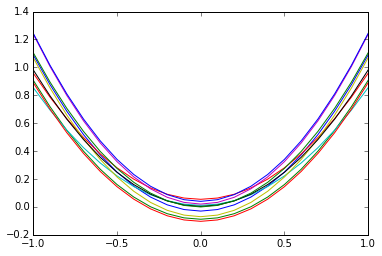

In [39]:
fitpoly = linfitter(poly10, x, data)
print(fitpoly)
fitdata = fitpoly(x, model_set_axis=False)
for i in fitdata:
    plt.plot(x, i)

### Compound models

astropy.modeling supports model combination using arithmetic operators and the specially defined join (&) and composition ( | ) operators.

In [51]:
g1 = models.Gaussian1D(2, 0, 0.2, name='g1') # models have names
g2 = models.Gaussian1D(3, 4, 1.5, name='g2')
p1 = models.Polynomial1D(1, c0=1, c1=0.2, name='poly')
model = g1 + g2 + p1

Evaluating "model" is equivalent to g1(x) + g2(x) + p1(x).

In [52]:
model(2.5) == g1(2.5) + g2(2.5) + p1(2.5)

True

The other arithmetic operators work similarly. The only requirement is that all models accept the same input.

Compound models support the `parameters` attribute the same way simple models do.

In [53]:
print(model.param_names)
print(model.parameters)

(u'amplitude_0', u'mean_0', u'stddev_0', u'amplitude_1', u'mean_1', u'stddev_1', u'c0_2', u'c1_2')
[ 2.   0.   0.2  3.   4.   1.5  1.   0.2]


In [54]:
model.amplitude_0 = 10
print(model.parameters)

[ 10.    0.    0.2   3.    4.    1.5   1.    0.2]


In [34]:
print(model.submodel_names)

('g1', 'g2', 'poly')


Compound models can be sliced or indexed using their names or numerical indices line python lists.

In [56]:
print(model['g2'])

Model: Gaussian1D
Name: g2
Inputs: (u'x',)
Outputs: (u'y',)
Model set size: 1
Parameters:
    amplitude mean stddev
    --------- ---- ------
          3.0  4.0    1.5


In [57]:
print(model['g2' : ])

Model: CompoundModel2
Inputs: (u'x',)
Outputs: (u'y',)
Model set size: 1
Parameters:
    amplitude_1 mean_1 stddev_1 c0_2 c1_2
    ----------- ------ -------- ---- ----
            3.0    4.0      1.5  1.0  0.2


The composition operator, |, combines models serially by chaining them one after the other. The number of outputs of a model must match the number of inputs of the next one.

In [59]:
p2_1 = models.Polynomial2D(degree=1, c0_0=2, c0_1=.1, c1_0=2, name='Poly_X')
rot = models.Rotation2D(angle=23.1, name='Rotation')

In [60]:
broken_model = p2_1 | rot 

ModelDefinitionError: Unsupported operands for |: Poly_X (n_inputs=2, n_outputs=1) and Rotation (n_inputs=2, n_outputs=2); n_outputs for the left-hand model must match n_inputs for the right-hand model.

The join operator, &, evaluates the child models on independent inputs and the results are concatenated.
The number of inputs passed to the combined model must equal the total number of inputs of all models.

In [61]:
p2_2 = models.Polynomial2D(degree=1, c0_0=1, c1_0=2, name='Poly_Y')
model = p2_1 & p2_2 | rot

In [62]:
#x = np.linspace(1, 10, 23)
#y = np.linspace(-10, 10, 23)
#plt.imshow(model(x, y, x, y))
x = 1.2
y = 1.4
print(model(x, y, x, y))

(2.8420434013885805, 4.908603600274077)


The `Mapping` model takes a tuple of indices into the inputs and returns the corresponding inputs. It is useful for changing the order of inputs, dropping or adding inputs. 

In [39]:
model = models.Mapping((0, 1, 0, 1)) | p2_1 & p2_2 | rot
print(model(x, y))

(2.8420434013885805, 4.908603600274077)


Compound models also support parameter constraints. Constraints are defined on parameters of the compound model, not parameters of the submodels.

In [ ]:
from astropy.io import ascii
sdss = ascii.read('data/sample_sdss.txt')
sdss.colnames

<IPython.core.display.Javascript object>


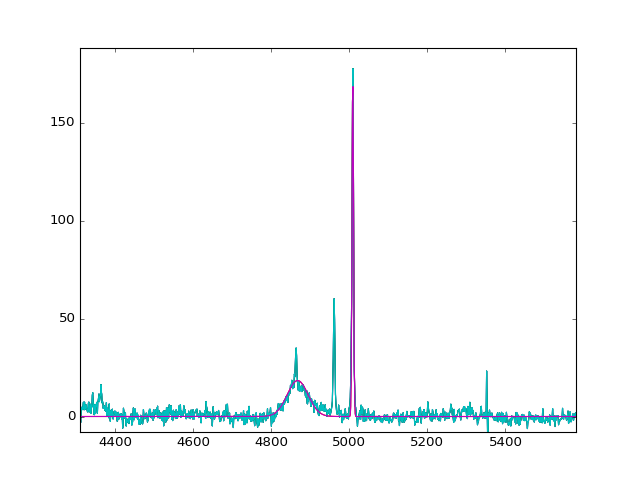

In [93]:
wave = sdss['lambda']
flux = sdss['flux']
%matplotlib notebook
plt.plot(wave, flux)


Using the rest wavelengths as initial values for the locaiton of the lines.

In [111]:
Hbeta = 4862.721
Halpha = 6564.614
OIII_1 = 4958.911
OIII_2 = 5008.239
Na = 6549.86
Nb = 6585.27
Sa = 6718.29
Sb = 6732.68

In [119]:
mean_flux = flux.mean()
cont = np.where(flux > mean_flux, mean_flux, flux)
poly_cont = linfitter(models.Polynomial1D(1), wave, cont)
print(poly_cont)

Model: Polynomial1D
Inputs: (u'x',)
Outputs: (u'y',)
Model set size: 1
Degree: 1
Parameters:
           c0               c1       
    --------------- -----------------
    -0.801238355842 9.79731629578e-05


In [120]:
h_beta = models.Gaussian1D(amplitude=34, mean=Hbeta, stddev=5)
o3 = models.Gaussian1D(amplitude=170, mean=OIII_2, stddev=5)
o1 = models.Gaussian1D(amplitude=57, mean=OIII_1, stddev=5)
hbeta_combo = h_beta + o1 + o3 + poly_cont
print(hbeta_combo.param_names)

(u'amplitude_0', u'mean_0', u'stddev_0', u'amplitude_1', u'mean_1', u'stddev_1', u'amplitude_2', u'mean_2', u'stddev_2', u'c0_3', u'c1_3')


In [121]:
def tie_ampl(model):
    return model.amplitude_2 / 3.1
hbeta_combo.amplitude_1.tied = tie_ampl

In [122]:
def tie_wave(model):
    return model.mean_0 * OIII_1/Hbeta
hbeta_combo.mean_1.tied = tie_wave 

<IPython.core.display.Javascript object>


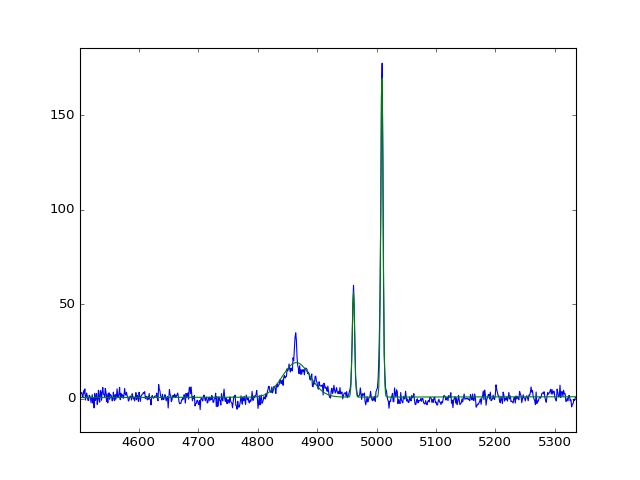

In [124]:
fitter = fitting.LevMarLSQFitter()
fitted_model = fitter(hbeta_combo, wave, flux)
fitted_lines = fitted_model(wave)
plt.plot(wave, flux)
plt.plot(wave, fitted_lines)

Exercise:

Fit a constraint model using all lines whose rest wavelengths are listed above.

### Inverse of a model

Models have their analytical inverse, if available, already defined. It is also possible to assign a "custom_inverse" by assigning a model to the `inverse` attribute.

In [63]:
print(rot.inverse)

Model: Rotation2D
Inputs: (u'x', u'y')
Outputs: (u'x', u'y')
Model set size: 1
Parameters:
    angle
    -----
    -23.1


In [64]:
print(p2_2.inverse)

NotImplementedError: An analytical inverse transform has not been implemented for this model.

In [65]:
p2_2.inverse = p2_1
print(p2_2.inverse)

Model: Polynomial2D
Name: Poly_X
Inputs: (u'x', u'y')
Outputs: (u'z',)
Model set size: 1
Degree: 1
Parameters:
    c0_0 c1_0 c0_1
    ---- ---- ----
     2.0  2.0  0.1


### Creating a new model

In [100]:
print(fitted_model[0])
print(fitted_model[1])
print(fitted_model[2])

Model: Gaussian1D
Inputs: (u'x',)
Outputs: (u'y',)
Model set size: 1
Parameters:
      amplitude        mean        stddev   
    ------------- ------------- ------------
    18.3507035983 4867.79836342 26.794859443
Model: Gaussian1D
Inputs: (u'x',)
Outputs: (u'y',)
Model set size: 1
Parameters:
      amplitude        mean     stddev
    ------------- ------------- ------
    533.676889906 1.02993411041    5.0
Model: Gaussian1D
Inputs: (u'x',)
Outputs: (u'y',)
Model set size: 1
Parameters:
      amplitude        mean         stddev   
    ------------- ------------- -------------
    172.153835453 5009.02448563 2.00921423431


Quite a few models are already defined in modeling.

In [43]:
models.

SyntaxError: invalid syntax (<ipython-input-43-9e08975948ee>, line 1)

A new model can be easily define following an existing model as an example.
However, there's also a decorator, which works with user defined functions and turns them onto models.

In [66]:
from astropy.modeling.models import custom_model
@custom_model
def sine_model(x, amplitude=1, frequency=1):
    return amplitude * np.sin(2 * np.pi * frequency * x)

model = sine_model(amplitude=3, frequency=2.1) # initialize the model
print(model(0.25))

-0.469303395121


In case a user wants to supply also a derivative, then `custom_model` can be used as a funciton

In [67]:
def sine_model(x, amplitude=1, frequency=1):
    return amplitude * np.sin(2 * np.pi * frequency * x)

def sine_deriv(x, amplitude=1, frequency=1):
    return 2 * np.pi * amplitude * np.cos(2 * np.pi * frequency *x)

SineModel = custom_model(sine_model, fit_deriv=sine_deriv) # create the class
model = SineModel(3, 2.1)# and initialize the model
print(model(0.25))

-0.469303395121
